In [2]:
import pandas as pd
import numpy as np
import random 
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import duckdb
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#한글 깨짐 방지지 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
data_path = Path('../data')

train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')

#데이터 구조 확인
train.head()

,ID,age,gender,tenure,frequent,payment_interval,subscription_type,contract_length,after_interaction,support_needs
0,TRAIN_00000,54.0,F,47.0,22.0,8.0,member,90,25.0,0
1,TRAIN_00001,30.0,M,16.0,15.0,5.0,vip,360,23.0,0
2,TRAIN_00002,29.0,M,8.0,30.0,21.0,plus,30,21.0,0
3,TRAIN_00003,38.0,F,38.0,23.0,10.0,vip,90,6.0,0
4,TRAIN_00004,25.0,F,52.0,3.0,17.0,member,30,1.0,2


In [5]:
#EDA
train.describe()
train_cols = [col for col in train.columns if 'ID' not in col]

print(train_cols)

train['subscription_type'].value_counts()

['age', 'gender', 'tenure', 'frequent', 'payment_interval', 'subscription_type', 'contract_length', 'after_interaction', 'support_needs']


subscription_type
plus      10481
vip       10405
member     9972
Name: count, dtype: int64

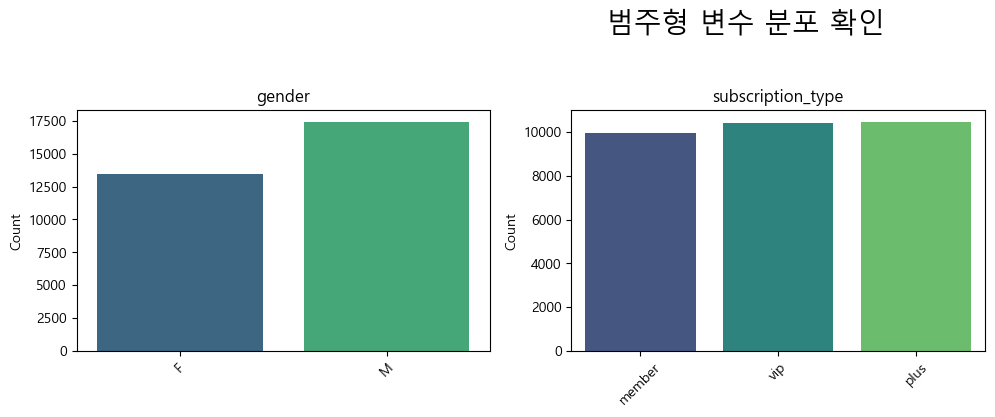

In [6]:
#범주형 변수 리스트
categorical_vars = [
    'gender', 'subscription_type', 
]

#그래프 그리기기
plt.figure(figsize=(15, 10))
plt.suptitle('범주형 변수 분포 확인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.countplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

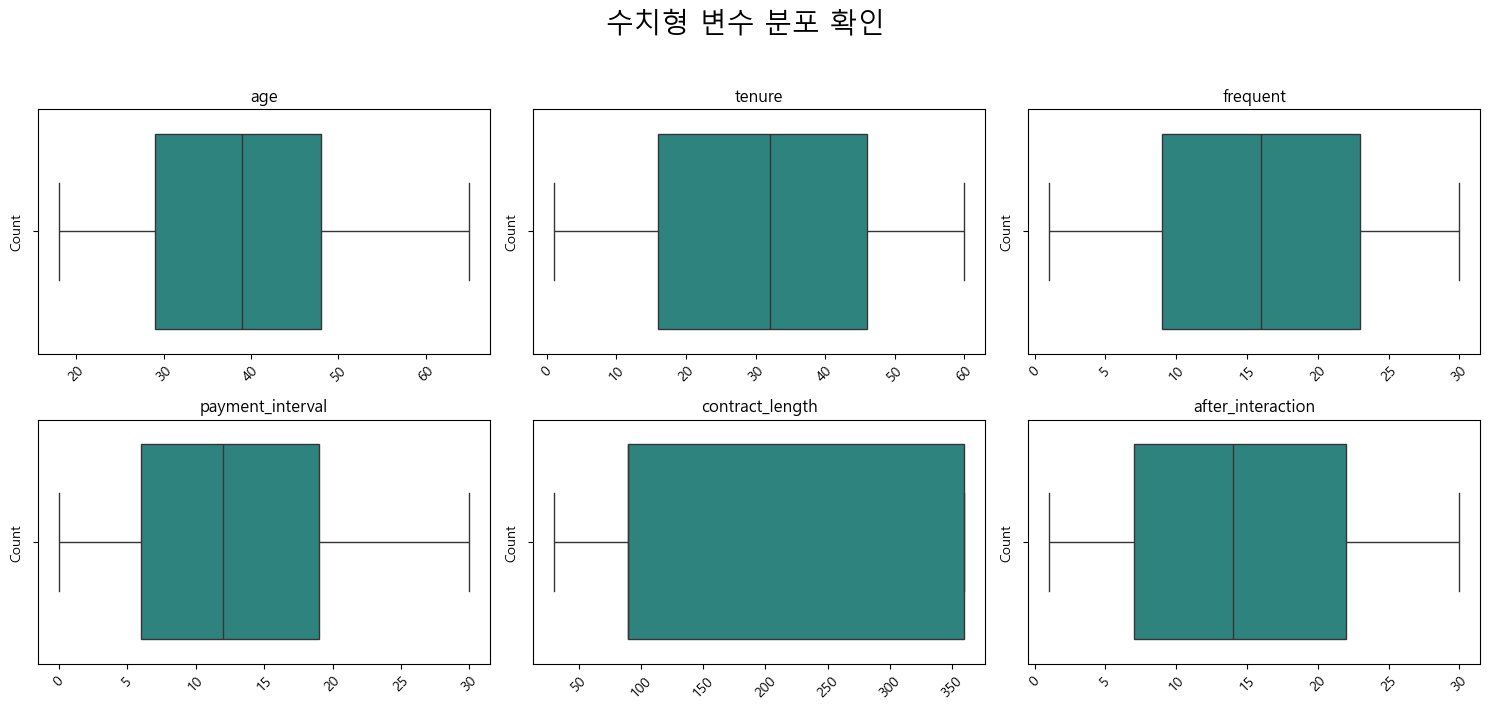

In [7]:
# 수치형 변수 리스트
numerical_vars = ['age', 'tenure', 'frequent', 'payment_interval', 'contract_length', 'after_interaction']

#그래프 그리기기
plt.figure(figsize=(15, 10))
plt.suptitle('수치형 변수 분포 확인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(numerical_vars , 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.boxplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 피처 엔지니어링

In [11]:
train.head()

,ID,age,gender,tenure,frequent,payment_interval,subscription_type,contract_length,after_interaction,support_needs
0,TRAIN_00000,54.0,F,47.0,22.0,8.0,member,90,25.0,0
1,TRAIN_00001,30.0,M,16.0,15.0,5.0,vip,360,23.0,0
2,TRAIN_00002,29.0,M,8.0,30.0,21.0,plus,30,21.0,0
3,TRAIN_00003,38.0,F,38.0,23.0,10.0,vip,90,6.0,0
4,TRAIN_00004,25.0,F,52.0,3.0,17.0,member,30,1.0,2


### ID : 샘플별 고유 ID
### age : 고객 나이
### gender : 고객 성별
### tenure : 고객이 서비스를 이용한 총 기간 (월)
### frequent : 고객의 서비스 이용일
### payment_interval : 고객의 결제 지연일
### subscription_type : 고객의 서비스 등급
### contract_length : 고객의 서비스 계약 기간
### after_interaction : 고객이 최근 서비스 이용으로부터 경과한 기간 (일)
### support_needs : 고객의 지원 필요도 (0 : 낮음 , 1 : 중간 , 2 : 높음)

In [ ]:
query = """
SELECT 
    ID,
    age, 
    gender, 
    tenure AS total_month, 
    frequent AS total_day,
    payment_interval,
    subscription_type,
    contract_length,
    after_interaction,
    support_needs, -- 쉼표 추가
    frequent / 30 AS MPR,
    tenure / age AS membership_duration_ratio ,
    payment_interval/ 30 AS late_payment_rate,
    after_interaction / contract_length AS elapsed_time_ratio,
    support_needs # TARGET
FROM train;
"""

train_fe = duckdb.query(query).to_df()
train_fe.head()

,ID,age,gender,total_month,total_day,payment_interval,subscription_type,contract_length,after_interaction,support_needs,MPR,membership_duration_ratio,late_payment_rate,elapsed_time_ratio,support_needs_1
0,TRAIN_00000,54.0,F,47.0,22.0,8.0,member,90,25.0,0,0.733333,0.870370,0.266667,0.277778,0
1,TRAIN_00001,30.0,M,16.0,15.0,5.0,vip,360,23.0,0,0.500000,0.533333,0.166667,0.063889,0
2,TRAIN_00002,29.0,M,8.0,30.0,21.0,plus,30,21.0,0,1.000000,0.275862,0.700000,0.700000,0
3,TRAIN_00003,38.0,F,38.0,23.0,10.0,vip,90,6.0,0,0.766667,1.000000,0.333333,0.066667,0
4,TRAIN_00004,25.0,F,52.0,3.0,17.0,member,30,1.0,2,0.100000,2.080000,0.566667,0.033333,2


In [33]:
test.head()

,ID,age,gender,tenure,frequent,payment_interval,subscription_type,contract_length,after_interaction
0,TEST_00000,18.0,M,40.0,6.0,15.0,member,30,18.0
1,TEST_00001,40.0,M,41.0,23.0,0.0,member,90,16.0
2,TEST_00002,59.0,F,30.0,1.0,21.0,member,360,25.0
3,TEST_00003,38.0,M,2.0,10.0,0.0,member,30,18.0
4,TEST_00004,30.0,M,28.0,21.0,20.0,member,360,28.0


In [37]:
query = """
SELECT 
    ID,
    age,
    gender,
    tenure AS total_month,
    frequent AS total_day,
    payment_interval,
    subscription_type,
    contract_length,
    after_interaction,
    frequent / 30 AS MPR,
    tenure / age AS membership_duration_ratio ,
    payment_interval/ 30 AS late_payment_rate,
    after_interaction / contract_length AS elapsed_time_ratio
FROM test;
"""

test_fe = duckdb.query(query).to_df()
test_fe.head()

,ID,age,gender,total_month,total_day,payment_interval,subscription_type,contract_length,after_interaction,MPR,membership_duration_ratio,late_payment_rate,elapsed_time_ratio
0,TEST_00000,18.0,M,40.0,6.0,15.0,member,30,18.0,0.200000,2.222222,0.500000,0.600000
1,TEST_00001,40.0,M,41.0,23.0,0.0,member,90,16.0,0.766667,1.025000,0.000000,0.177778
2,TEST_00002,59.0,F,30.0,1.0,21.0,member,360,25.0,0.033333,0.508475,0.700000,0.069444
3,TEST_00003,38.0,M,2.0,10.0,0.0,member,30,18.0,0.333333,0.052632,0.000000,0.600000
4,TEST_00004,30.0,M,28.0,21.0,20.0,member,360,28.0,0.700000,0.933333,0.666667,0.077778


In [44]:
#범주형 변수 인코딩
train_fe['gender'] = train_fe['gender'].map({'F':0, "M": 1})
test_fe['gender'] = test_fe['gender'].map({'F':0, "M": 1})

train_fe['subscription_type'] = train_fe['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})
test_fe['subscription_type'] = test_fe['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})


In [56]:
x_train = train_fe.drop(columns =['ID','support_needs','support_needs_1'])
x_test = test_fe.drop(columns = ['ID'])
y_train = train_fe['support_needs_1']


In [57]:
x_train.head()

,age,gender,total_month,total_day,payment_interval,subscription_type,contract_length,after_interaction,MPR,membership_duration_ratio,late_payment_rate,elapsed_time_ratio
0,54.0,0,47.0,22.0,8.0,0,90,25.0,0.733333,0.870370,0.266667,0.277778
1,30.0,1,16.0,15.0,5.0,2,360,23.0,0.500000,0.533333,0.166667,0.063889
2,29.0,1,8.0,30.0,21.0,1,30,21.0,1.000000,0.275862,0.700000,0.700000
3,38.0,0,38.0,23.0,10.0,2,90,6.0,0.766667,1.000000,0.333333,0.066667
4,25.0,0,52.0,3.0,17.0,0,30,1.0,0.100000,2.080000,0.566667,0.033333


In [58]:
y_train.head()

0    0
1    0
2    0
3    0
4    2
Name: support_needs_1, dtype: int64

In [59]:
x_test.head()

,age,gender,total_month,total_day,payment_interval,subscription_type,contract_length,after_interaction,MPR,membership_duration_ratio,late_payment_rate,elapsed_time_ratio
0,18.0,1,40.0,6.0,15.0,0,30,18.0,0.200000,2.222222,0.500000,0.600000
1,40.0,1,41.0,23.0,0.0,0,90,16.0,0.766667,1.025000,0.000000,0.177778
2,59.0,0,30.0,1.0,21.0,0,360,25.0,0.033333,0.508475,0.700000,0.069444
3,38.0,1,2.0,10.0,0.0,0,30,18.0,0.333333,0.052632,0.000000,0.600000
4,30.0,1,28.0,21.0,20.0,0,360,28.0,0.700000,0.933333,0.666667,0.077778


In [60]:
#수치형 변수 인코딩
numerical_cols = ['age'	,	'total_month',	'total_day',	'payment_interval'	,	'contract_length',	'after_interaction'	,'MPR',	'membership_duration_ratio',	'late_payment_rate','elapsed_time_ratio']
scaler = StandardScaler()
x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])

In [62]:
from sklearn.model_selection import GridSearchCV

# 1. 탐색할 하이퍼파라미터 후보들을 정의합니다.
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

# 2. GridSearchCV 객체 생성
# estimator에 tree_method='gpu_hist'를 추가합니다.
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        tree_method='gpu_hist',  # GPU 사용 설정
        random_state=42,
        objective='multi:softprob',
        eval_metric='mlogloss'
    ),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    verbose=1,
    n_jobs=1  # GPU 사용 시에는 n_jobs를 1로 설정하는 것이 안정적입니다.
)

# 3. 최적의 파라미터 탐색 시작 (이제 GPU로 연산이 수행됩니다)
grid_search.fit(x_train, y_train)

# 4. 최적의 파라미터와 최고 점수 확인
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도:", grid_search.best_score_)

# 5. 최적의 모델로 예측
best_model = grid_search.best_estimator_
preds_tuned = best_model.predict(x_test)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
최고 정확도: 0.5358092015911246


In [63]:
best_model = grid_search.best_estimator_

preds_final = best_model.predict(x_test)


# 2. 제출 파일 생성
# data_path는 실제 경로에 맞게 설정해야 합니다.
# 예: data_path = Path('./data')
submission = pd.read_csv(data_path/'sample_submission.csv')
submission['support_needs'] = preds_final
submission.to_csv('xgb_tuned_submission.csv', index=False)

print("GridSearchCV로 찾은 최적 XGBoost 모델 예측 완료 및 제출 파일 생성!")

GridSearchCV로 찾은 최적 XGBoost 모델 예측 완료 및 제출 파일 생성!
